In [2]:
!pip install catboost
!pip install lightgbm
!pip install xgboost

In [2]:
from google.colab import drive

drive.mount("/content/gdrive")

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
%cd /content/gdrive/MyDrive/weather_contest/electric

In [3]:
import os
print(os.getcwd())

C:\Users\jsgat\anaconda_document\weather


In [3]:
import sys
sys.path.append('..')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# from utils.util import *
from util import clean_column_names
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
# %reload_ext autotime

In [4]:
org=pd.read_csv("electric_train.csv")
test = pd.read_csv("electric_test.csv")

df = org.copy()

In [5]:
df = clean_column_names(df)
df['날짜'] = pd.to_datetime(df['날짜'])

df

,격자넘버,날짜,시간,공동주택수,지점번호,계약전력합계,전력수요_합계,전력부하량_평균,기온,상대습도,풍속,강수량,체감온도,요일,주중_주말,전력기상지수
0,4821,2021-01-01 01:00:00,1,11,884,6950,751.32,68.606449,2.2,62.7,1.8,0.0,-1.0,4,0,99.56
1,4821,2021-01-01 02:00:00,2,11,884,6950,692.60,68.606449,2.3,63.1,2.1,0.0,-0.6,4,0,91.78
2,4821,2021-01-01 03:00:00,3,11,884,6950,597.48,68.606449,2.2,62.4,2.5,0.0,-1.3,4,0,79.17
3,4821,2021-01-01 04:00:00,4,11,884,6950,553.48,68.606449,1.7,63.5,1.7,0.0,-0.2,4,0,73.34
4,4821,2021-01-01 05:00:00,5,11,884,6950,526.24,68.606449,1.7,63.0,1.6,0.0,-0.8,4,0,69.73
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7593350,20947,2022-12-31 20:00:00,20,23,671,34200,6779.84,225.461986,2.7,46.3,3.1,0.0,-0.4,5,1,130.74
7593351,20947,2022-12-31 21:00:00,21,23,671,34200,6802.40,225.461986,2.6,46.8,3.1,0.0,-0.5,5,1,131.18
7593352,20947,2022-12-31 22:00:00,22,23,671,34200,6706.68,225.461986,2.4,47.4,2.1,0.0,0.2,5,1,129.33
7593353,20947,2022-12-31 23:00:00,23,23,671,34200,6355.88,225.461986,2.5,47.0,2.1,0.0,0.3,5,1,122.57


# train set과 valid set

- train set: 2020년, 2021년
- valid set: 2022년

In [6]:
df.set_index('날짜').sort_index()

,격자넘버,시간,공동주택수,지점번호,계약전력합계,전력수요_합계,전력부하량_평균,기온,상대습도,풍속,강수량,체감온도,요일,주중_주말,전력기상지수
날짜,,,,,,,,,,,,,,,
2020-01-01 01:00:00,13615,1,39,140,63850,9732.96,250.490543,-8.5,74.5,0.9,0.0,-5.8,2,0,99.63
2020-01-01 01:00:00,18235,1,20,565,14750,2401.12,116.010234,-8.8,25.6,1.9,0.0,-4.6,2,0,103.49
2020-01-01 01:00:00,18234,1,32,565,71630,12139.16,363.252769,-8.8,25.6,1.9,0.0,-4.6,2,0,104.43
2020-01-01 01:00:00,18233,1,28,512,45840,6723.84,225.924357,-6.3,31.3,2.5,0.0,-7.8,2,0,106.29
2020-01-01 01:00:00,11272,1,44,941,76450,12949.24,287.250770,2.4,68.0,1.2,0.0,-5.3,2,0,102.45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-01 00:00:00,12468,24,40,152,50075,8018.88,187.277655,7.1,60.2,4.5,0.0,-2.3,6,1,107.05
2023-01-01 00:00:00,16453,24,57,617,85000,13949.76,228.064905,-5.5,81.1,0.2,0.0,-2.9,6,1,107.31
2023-01-01 00:00:00,11418,24,36,253,63735,11472.28,296.369472,5.6,59.5,1.3,0.0,-1.6,6,1,107.53


In [7]:
tmp = df.groupby(by='지점번호')['날짜'].agg(func=['max', 'min'])
tmp['기간'] = tmp['min'].dt.strftime('%Y-%m-%d') + ' ~ ' + tmp['max'].dt.strftime('%Y-%m-%d')

tmp

,max,min,기간
지점번호,,,
98,2023-01-01,2020-01-01 01:00:00,2020-01-01 ~ 2023-01-01
99,2021-01-01,2020-01-01 01:00:00,2020-01-01 ~ 2021-01-01
101,2023-01-01,2020-01-01 01:00:00,2020-01-01 ~ 2023-01-01
104,2023-01-01,2020-01-01 01:00:00,2020-01-01 ~ 2023-01-01
106,2022-01-01,2020-01-01 01:00:00,2020-01-01 ~ 2022-01-01
...,...,...,...
942,2023-01-01,2020-01-01 01:00:00,2020-01-01 ~ 2023-01-01
943,2023-01-01,2020-01-01 01:00:00,2020-01-01 ~ 2023-01-01
950,2023-01-01,2020-01-01 01:00:00,2020-01-01 ~ 2023-01-01


In [8]:
tmp['기간'].value_counts()

기간
2020-01-01 ~ 2023-01-01    158
2020-01-01 ~ 2022-01-01     12
2020-01-01 ~ 2021-01-01      6
2021-01-01 ~ 2022-01-01      5
2021-01-01 ~ 2023-01-01      3
2022-01-01 ~ 2023-01-01      1
Name: count, dtype: int64

In [9]:
mask = tmp[tmp['기간'] == '2020-01-01 ~ 2023-01-01'].index

mask

Index([ 98, 101, 104, 108, 112, 114, 119, 127, 129, 131,
       ...
       937, 938, 939, 940, 941, 942, 943, 950, 974, 991],
      dtype='int64', name='지점번호', length=158)

In [10]:
data = df[df['지점번호'].isin(mask)]
data = data.reset_index(drop=True)

In [11]:
data

,격자넘버,날짜,시간,공동주택수,지점번호,계약전력합계,전력수요_합계,전력부하량_평균,기온,상대습도,풍속,강수량,체감온도,요일,주중_주말,전력기상지수
0,5565,2020-01-01 01:00:00,1,58,184,42250,4468.72,79.776051,2.3,65.8,1.7,0.0,-0.3,2,0,96.58
1,5565,2020-01-01 02:00:00,2,58,184,42250,4101.00,79.776051,2.5,69.7,1.8,0.0,-0.2,2,0,88.63
2,5565,2020-01-01 03:00:00,3,58,184,42250,3724.60,79.776051,2.8,69.5,2.3,0.0,-0.2,2,0,80.50
3,5565,2020-01-01 04:00:00,4,58,184,42250,3484.40,79.776051,2.8,66.0,1.6,0.0,0.5,2,0,75.31
4,5565,2020-01-01 05:00:00,5,58,184,42250,3409.12,79.776051,3.0,66.1,1.6,0.0,0.5,2,0,73.68
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7198670,20947,2022-12-31 20:00:00,20,23,671,34200,6779.84,225.461986,2.7,46.3,3.1,0.0,-0.4,5,1,130.74
7198671,20947,2022-12-31 21:00:00,21,23,671,34200,6802.40,225.461986,2.6,46.8,3.1,0.0,-0.5,5,1,131.18
7198672,20947,2022-12-31 22:00:00,22,23,671,34200,6706.68,225.461986,2.4,47.4,2.1,0.0,0.2,5,1,129.33
7198673,20947,2022-12-31 23:00:00,23,23,671,34200,6355.88,225.461986,2.5,47.0,2.1,0.0,0.3,5,1,122.57


In [12]:
data['년'] = data['날짜'].dt.year
data['월'] = data['날짜'].dt.month
data['일'] = data['날짜'].dt.day
data['분기'] = data['날짜'].dt.quarter

train_data, valid_data = data[data['날짜'].dt.year < 2022], data[data['날짜'].dt.year >= 2022]

features = ['공동주택수', '계약전력합계', '전력수요_합계', '전력부하량_평균', '기온', '상대습도', '풍속', '강수량', '체감온도', '년', '월', '일', '시간', '요일', '분기', '지점번호']
X_train = train_data[features]
y_train = train_data['전력기상지수']
X_valid = valid_data[features]
y_valid = valid_data['전력기상지수']

numeric_features = ['공동주택수', '계약전력합계', '전력수요_합계', '전력부하량_평균', '기온', '상대습도', '풍속', '강수량', '체감온도', '년', '월', '일', '시간']
categorical_features = ['요일', '분기', '지점번호']

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# 칼럼 변환기 설정
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# 변환기 적용
X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)


print(X_train.shape)
print(X_valid.shape)

(4894519, 182)
(2304156, 182)


In [13]:
from util import get_rscore

In [45]:
# XGBRegressor 모델 학습
xgb_model = XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

# 예측
y_pred = xgb_model.predict(X_valid)

# 성능 평가
mse = mean_squared_error(y_valid, y_pred)
r_score = get_rscore(y_valid, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R Score: {r_score}')

Mean Squared Error: 39.70995050944442
R Score: 0.9701060725422864


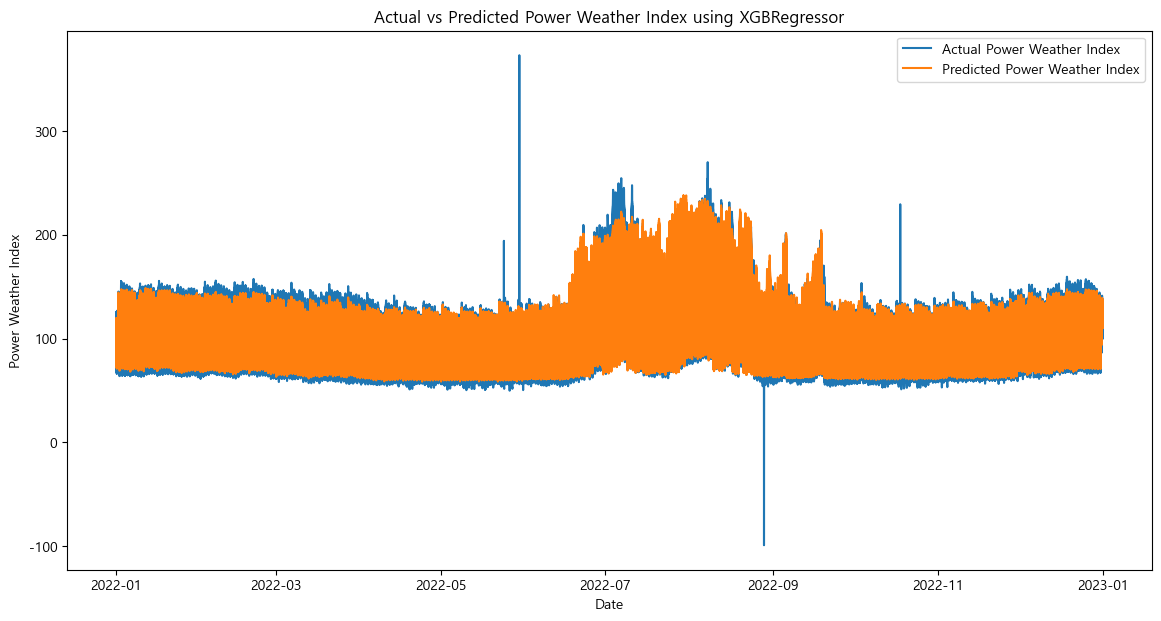

In [46]:
# 실제 값과 예측 값 비교 시각화
plt.figure(figsize=(14, 7))
plt.plot(valid_data['날짜'], y_valid, label='Actual Power Weather Index')
plt.plot(valid_data['날짜'], y_pred, label='Predicted Power Weather Index')
plt.xlabel('Date')
plt.ylabel('Power Weather Index')
plt.title('Actual vs Predicted Power Weather Index using XGBRegressor')
plt.legend()
plt.show()

In [14]:
X_train_dense = X_train.toarray()
X_valid_dense = X_valid.toarray()


In [18]:
lgbm_params = {
    'n_estimators': 1000,
    'learning_rate': 0.1,
    'num_leaves': 8,
    'min_child_samples': 12,
    'colsample_bytree': 0.96,
    'reg_alpha': 0.11,
    'reg_lambda': 0.80,
    # 다른 하이퍼파라미터 설정
}

lgbm_model = LGBMRegressor(**lgbm_params)

# 피팅
lgbm_model.fit(X_train_dense, y_train,
               eval_set=[(X_valid_dense, y_valid)],
               eval_metric='mse')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.236346 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2463
[LightGBM] [Info] Number of data points in the train set: 4894519, number of used features: 182
[LightGBM] [Info] Start training from score 99.998920


LGBMRegressor(colsample_bytree=0.96, min_child_samples=12, n_estimators=1000,
              num_leaves=8, reg_alpha=0.11, reg_lambda=0.8)

In [19]:
# 예측
y_pred = lgbm_model.predict(X_valid)

# 성능 평가
mse = mean_squared_error(y_valid, y_pred)
r_score = get_rscore(y_valid, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R Score: {r_score}')

Mean Squared Error: 27.621527186295708
R Score: 0.9793140699280156


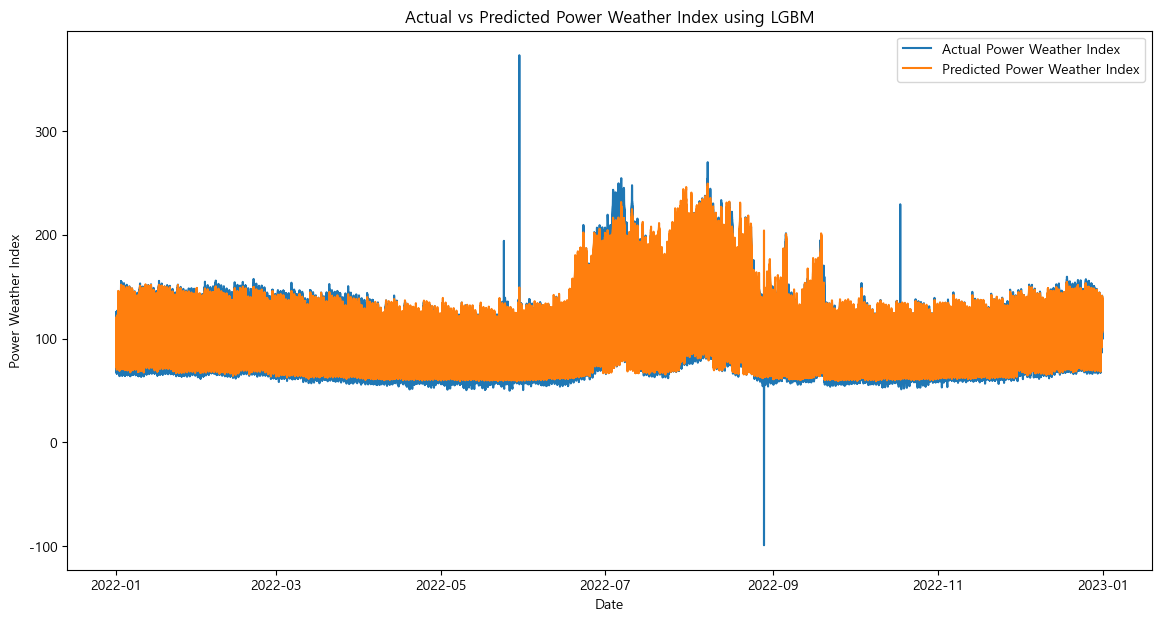

In [20]:
plt.figure(figsize=(14, 7))
plt.plot(valid_data['날짜'], y_valid, label='Actual Power Weather Index')
plt.plot(valid_data['날짜'], y_pred, label='Predicted Power Weather Index')
plt.xlabel('Date')
plt.ylabel('Power Weather Index')
plt.title('Actual vs Predicted Power Weather Index using LGBM')
plt.legend()
plt.show()

In [ ]:
# cat_params = {'learning_rate': 0.14,
#       'loss_function': 'RMSE',
#       'verbose': False,
#       'n_estimators': 7000,
#       'early_stopping_rounds': 100,
#       'objective': 'MAE',
#       }

# CAT_model = CatBoostRegressor(**cat_params)
# CAT_model.fit(X_train_dense,y_train)

In [15]:
cat_params1 = {'learning_rate': 0.14,
      'loss_function': 'RMSE',
      'verbose': False,
      'n_estimators': 1000,
      'early_stopping_rounds': 100,
      'objective': 'MAE',
      }

CAT_model1 = CatBoostRegressor(**cat_params1)
CAT_model1.fit(X_train_dense,y_train)

In [16]:
# 예측
y_pred1 = CAT_model1.predict(X_valid_dense)

# 성능 평가
mse = mean_squared_error(y_valid, y_pred1)
r_score = get_rscore(y_valid, y_pred1)

print(f'Mean Squared Error: {mse}')
print(f'R Score: {r_score}')

Mean Squared Error: 25.074078610542788
R Score: 0.9809076626266333


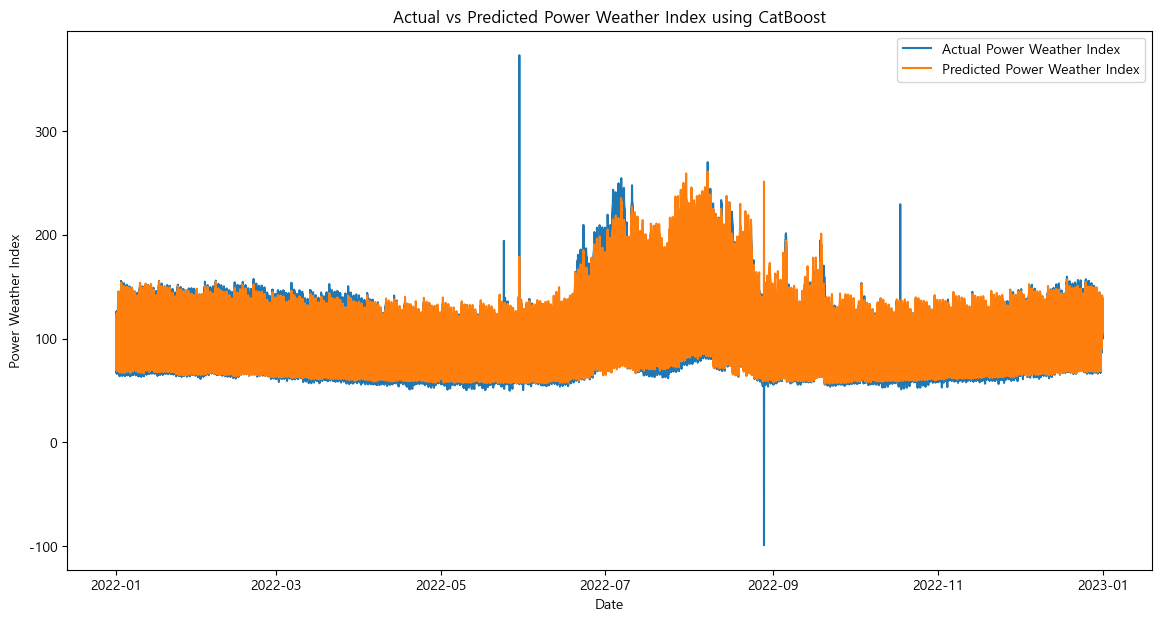

In [17]:
plt.figure(figsize=(14, 7))
plt.plot(valid_data['날짜'], y_valid, label='Actual Power Weather Index')
plt.plot(valid_data['날짜'], y_pred1, label='Predicted Power Weather Index')
plt.xlabel('Date')
plt.ylabel('Power Weather Index')
plt.title('Actual vs Predicted Power Weather Index using CatBoost')
plt.legend()
plt.show()